# WHO: Life Expectancy Dataset
**Project Goals**:
 - Wrangle WHO dataset to increase usability for project.
 - Utilize dataset to explore correlating features to life expectancy.
 - Create machine learning model to predict life expectancy.

In [1]:
import pandas as pd
import numpy as np
import wrangle
import explore

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from scipy import stats
from math import sqrt

import sklearn.preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression, SelectKBest, RFE

## Acquire Data

In [2]:
df = wrangle.acquire_who_data()

In [3]:
df.sample(5).T

,28,860,282,2215,781
Country,Albania,Eritrea,Benin,Samoa,Dominican Republic
Year,2003,2005,2005,2000,2004
Status,Developing,Developing,Developing,Developing,Developing
Life expectancy,72.8,59.4,56.5,72,69.3
Adult Mortality,18,34,285,18,214
infant deaths,1,7,25,0,7
Alcohol,4.29,1.07,1.13,3,5.16
percentage expenditure,14.7193,5.06469,7.107,21.2543,182.616
Hepatitis B,97,96,7,89,82
Measles,8,19,210,0,0


In [4]:
wrangle.get_info(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
2191,Saint Vincent and the Grenadines,2008,Developing,72.1,167.0,0,6.92,0.000000,99.0,0,...,99.0,4.70,99.0,0.3,NaN,NaN,3.6,3.6,0.704,13.3
2000,Paraguay,2006,Developing,72.3,161.0,3,5.61,26.180724,92.0,0,...,98.0,6.43,98.0,0.2,189.71539,5882796.0,2.2,2.2,0.648,12.1
612,Congo,2011,Developing,62.9,285.0,7,3.82,0.000000,7.0,315,...,69.0,2.79,82.0,3.5,NaN,NaN,8.0,7.6,0.558,10.7


### Acquire Takeaways:
 - I brought in my data using my acquire function
 - My info function gives me insight into the data types and null counts in my df
 - I will need to strip whitespaces from column names, lowercase and rename as well.
 - I will definitely need to impute some nulls because dropping would be too much
 - A distplot will give me a good idea of how to impute our nulls

## Prepare Data

In [5]:
df.dtypes

Country                             object
Year                                 int64
Status                              object
Life expectancy                    float64
Adult Mortality                    float64
infant deaths                        int64
Alcohol                            float64
percentage expenditure             float64
Hepatitis B                        float64
Measles                              int64
 BMI                               float64
under-five deaths                    int64
Polio                              float64
Total expenditure                  float64
Diphtheria                         float64
 HIV/AIDS                          float64
GDP                                float64
Population                         float64
 thinness  1-19 years              float64
 thinness 5-9 years                float64
Income composition of resources    float64
Schooling                          float64
dtype: object

In [6]:
df = wrangle.prep_who(df)

In [7]:
df.head()

,country,year,developed_country,life_expectancy,adult_mortality,infant_deaths,alcohol,pct_expenditure,hep_b,measles,...,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness_10-19yrs,thinness_5-9yrs,income_comp_resources,yrs_education
0,Afghanistan,2015,0,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,0,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,0,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,0,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,0,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


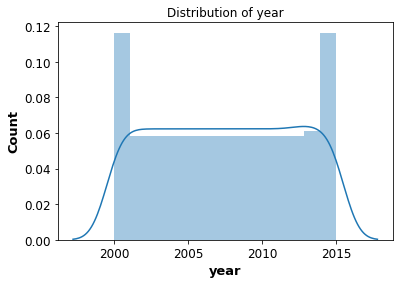

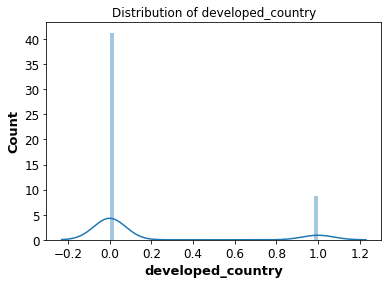

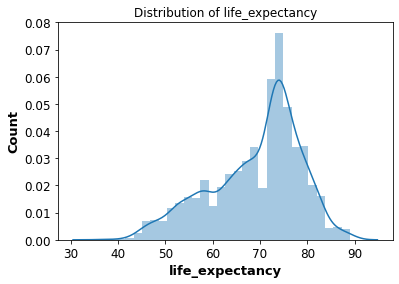

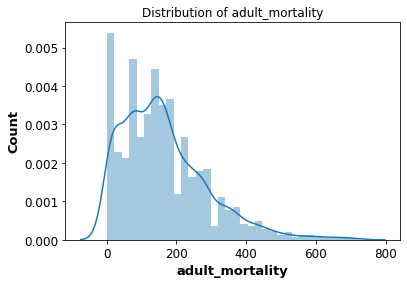

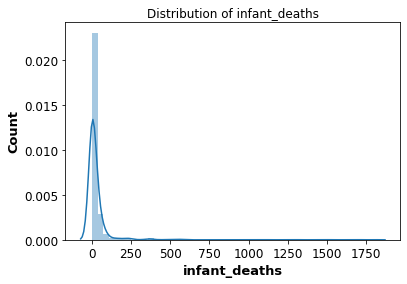

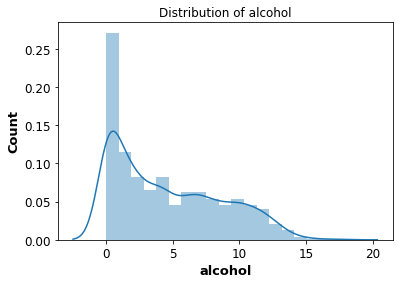

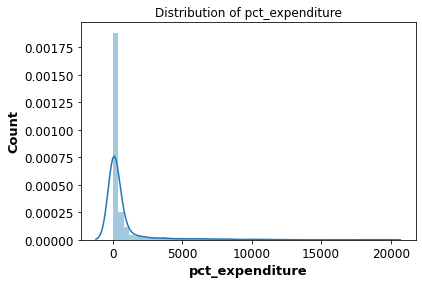

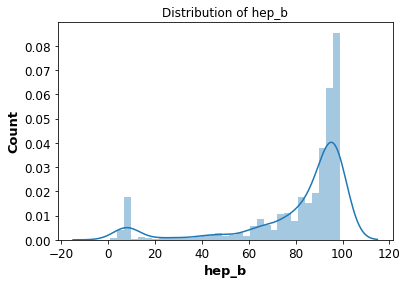

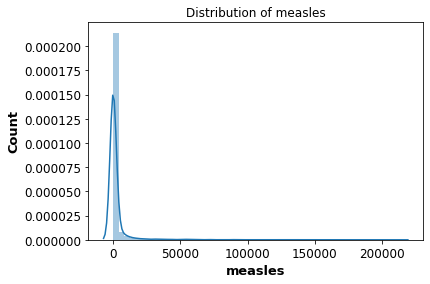

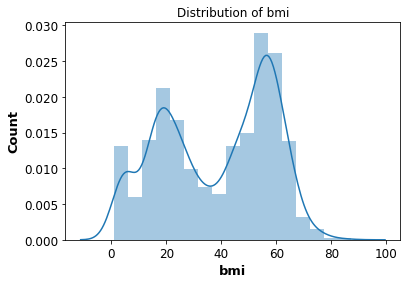

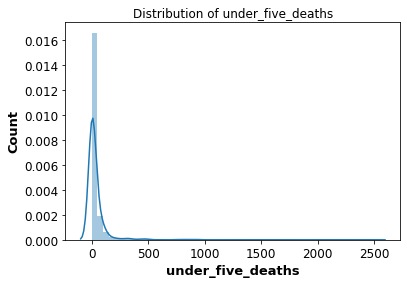

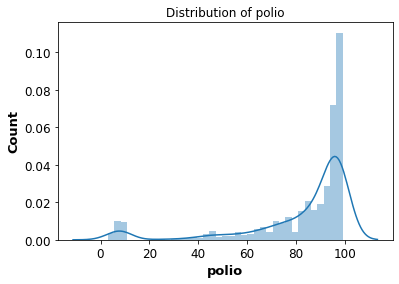

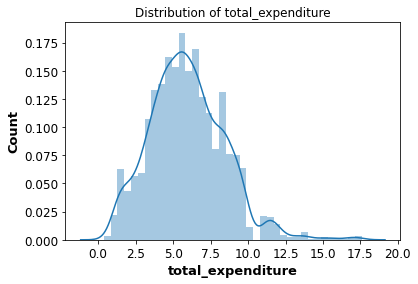

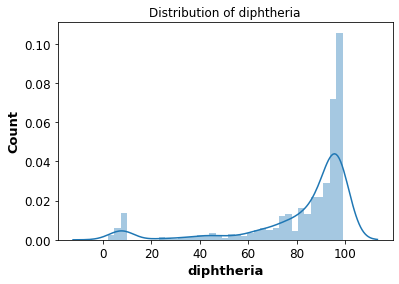

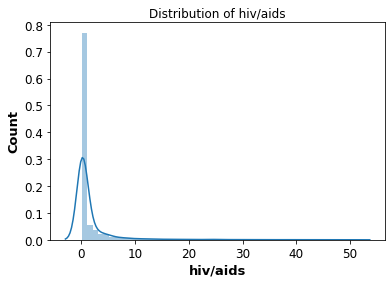

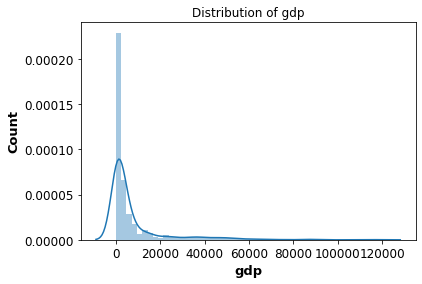

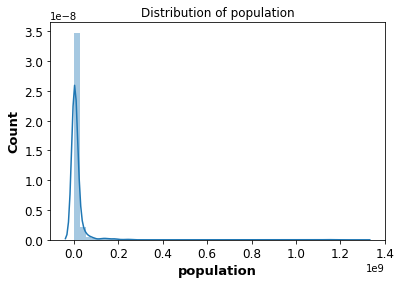

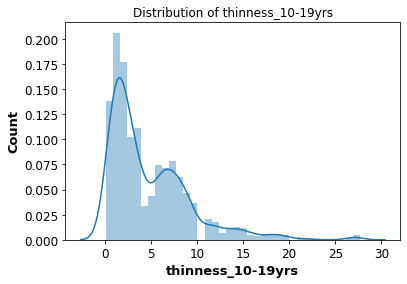

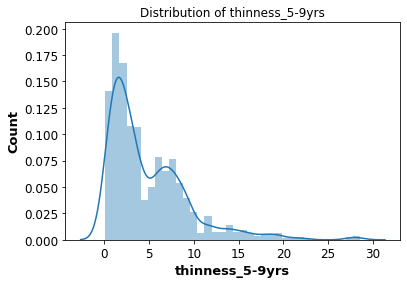

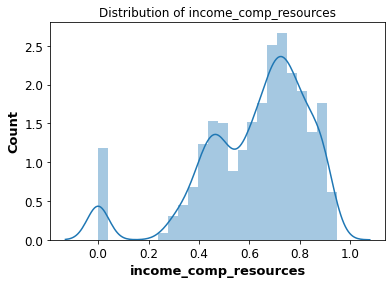

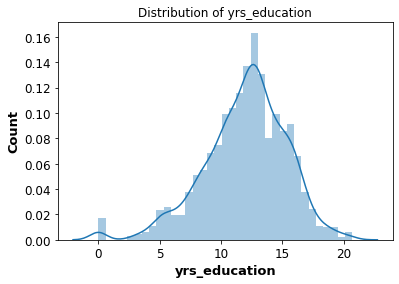

In [8]:
# take a look at distributions of numerical columns using my distplot function 
# get a better handle on the distribution to impute null entries
explore.distplot(df, df.columns)

In [9]:
df.sample(10).T

,1965,324,149,817,1423,478,1312,107,2481,116
country,Panama,Bosnia and Herzegovina,Azerbaijan,Egypt,Kyrgyzstan,Cambodia,Jamaica,Armenia,Suriname,Australia
year,2009,2011,2010,2000,2002,2001,2001,2004,2007,2011
developed_country,0,0,0,0,0,0,0,0,0,1
life_expectancy,76.8,76.9,71.1,68.8,66.7,58.5,72.7,73,69.5,82
adult_mortality,127,92,13,171,215,273,171,132,22,63
infant_deaths,1,0,5,65,4,25,1,1,0,1
alcohol,6.87,4.64,1.98,0.14,3.31,1.71,3.89,3.81,4.72,10.3
pct_expenditure,1092.16,7.95913,246.569,0,0,27.6897,160.238,97.7409,685.03,10986.3
hep_b,85,88,8,98,99,NaN,NaN,91,84,92
measles,0,10,0,2633,2,3761,0,1783,0,190


In [10]:
# investigate the nulls
df.isnull().sum()

country                    0
year                       0
developed_country          0
life_expectancy           10
adult_mortality           10
infant_deaths              0
alcohol                  194
pct_expenditure            0
hep_b                    553
measles                    0
bmi                       34
under_five_deaths          0
polio                     19
total_expenditure        226
diphtheria                19
hiv/aids                   0
gdp                      448
population               652
thinness_10-19yrs         34
thinness_5-9yrs           34
income_comp_resources    167
yrs_education            163
dtype: int64

In [11]:
# handle the nulls using the function I created for the dataframe
df = wrangle.handle_who_nulls(df)

In [12]:
# double check nulls are handled
df.isnull().sum()

country              0
year                 0
developed_country    0
life_expectancy      0
adult_mortality      0
infant_deaths        0
alcohol              0
pct_expenditure      0
hep_b                0
measles              0
bmi                  0
under_five_deaths    0
polio                0
total_expenditure    0
diphtheria           0
hiv/aids             0
thinness_10-19yrs    0
thinness_5-9yrs      0
yrs_education        0
dtype: int64

In [13]:
# check how much of the data we're left with
df.shape

(2709, 19)

In [14]:
# split data for exploration and scaling
train, validate, test = wrangle.split_data(df)

train---> (1516, 19)
validate---> (651, 19)
test---> (542, 19)


In [15]:
# use robust scaler on my dataframe, using robust because some of the data is skewed and 
# has some outliers that cannot be addressed

# assign the columns I want to scale
numeric_cols = ['year', 'adult_mortality', 'infant_deaths', 'pct_expenditure',
               'measles', 'under_five_deaths', 'yrs_education']

# use my robust scaler function to scaled my X dataframes
train_scaled, validate_scaled, test_scaled, numeric_cols = wrangle.robust_scaler(train, validate, test, numeric_cols)

### Prepare Takeaways:
 - Used my prep function to rename columns and hot encode developed countries into discrete variable
 - Visualized distribution to assess how to fill my null values and which were necessary to drop
 - Created a handle nulls function to impute null values with mean average and backfill values grouped by country
 - Split my data for exploration and modeling
 - Used robust scaler to scale my numeric columns

## Explore

In [16]:
# visualize distribution of ytarget
train_scaled.sample(5).T

,1947,688,1078,1574,2608
country,Pakistan,Cyprus,Guinea,Malawi,Timor-Leste
year,0.375,-0.875,0.5,0.5,0.125
developed_country,0,1,0,0,0
life_expectancy,65.1,78.1,58.1,54.1,66.2
adult_mortality,0.166389,-0.93178,-0.785358,1.95674,0.139767
infant_deaths,16.0435,-0.130435,1.08696,1.26087,-0.0434783
alcohol,0.04,9.56,0.22,1.23,0.06
pct_expenditure,-0.159537,2.23937,-0.0545369,-0.12644,-0.0685819
hep_b,82,89,63,97,79
measles,10.9561,-0.0458307,-0.017823,0.0203692,-0.0458307


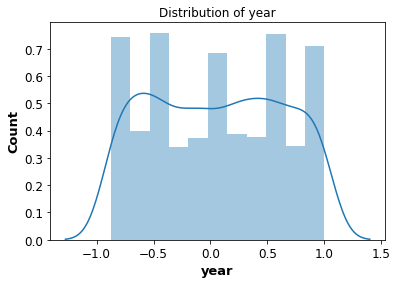

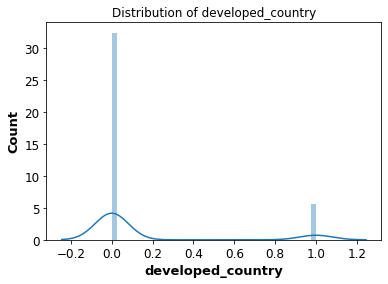

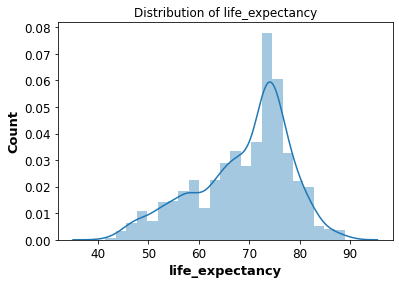

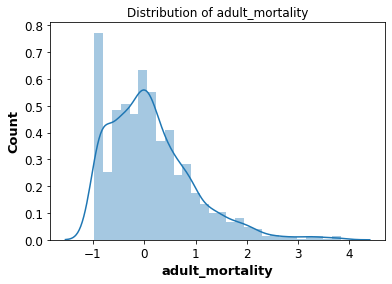

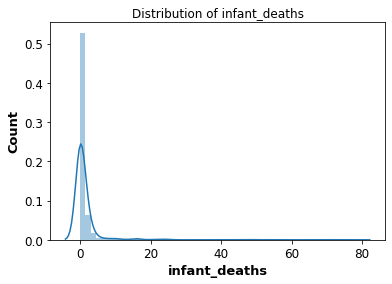

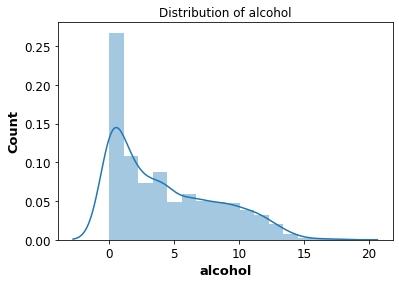

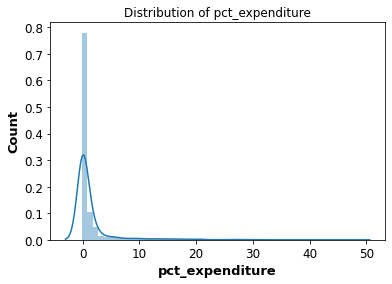

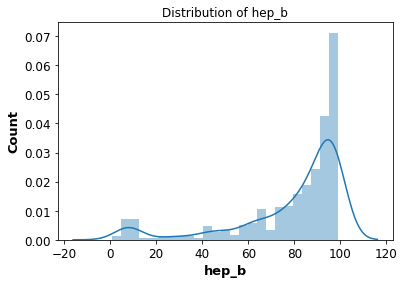

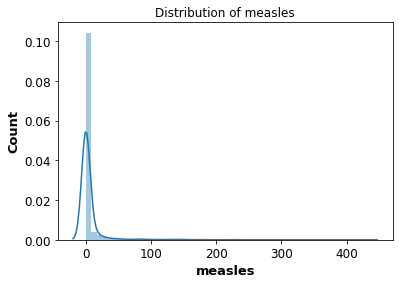

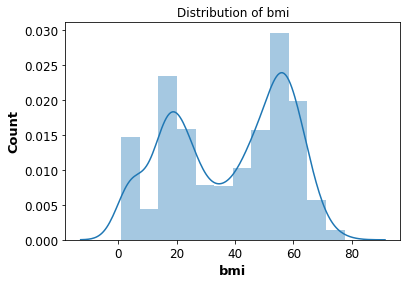

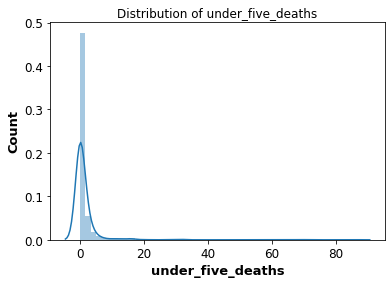

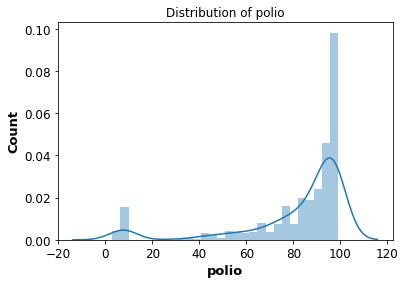

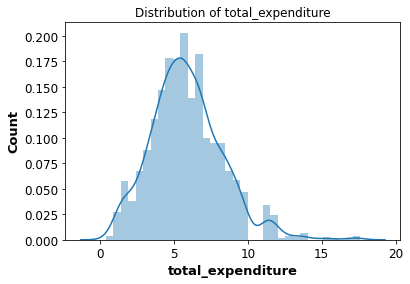

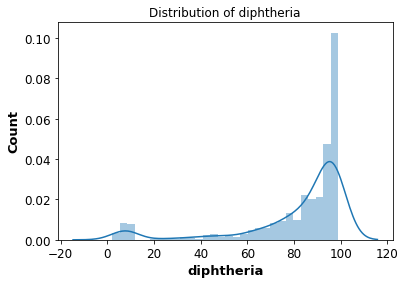

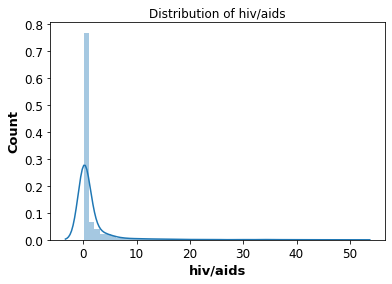

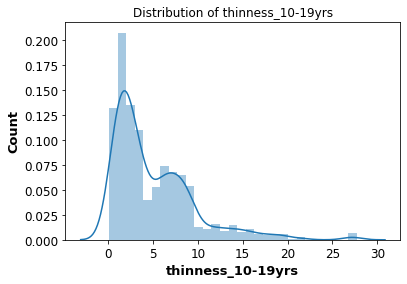

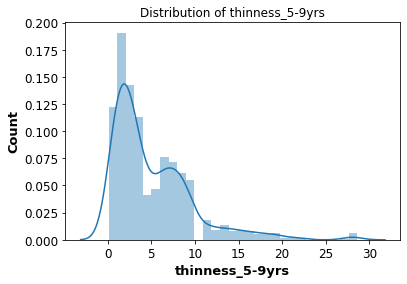

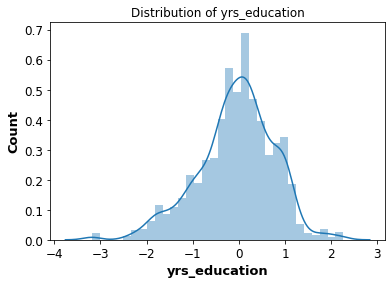

In [17]:
explore.distplot(train_scaled, train_scaled.columns)

In [18]:
train_scaled.dtypes

country               object
year                 float64
developed_country      int64
life_expectancy      float64
adult_mortality      float64
infant_deaths        float64
alcohol              float64
pct_expenditure      float64
hep_b                float64
measles              float64
bmi                  float64
under_five_deaths    float64
polio                float64
total_expenditure    float64
diphtheria           float64
hiv/aids             float64
thinness_10-19yrs    float64
thinness_5-9yrs      float64
yrs_education        float64
dtype: object

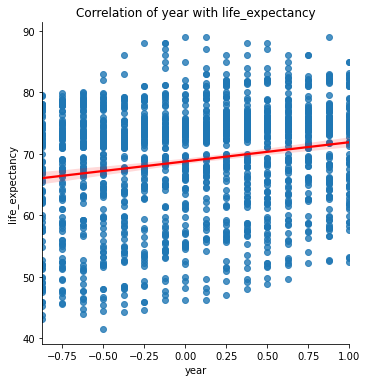

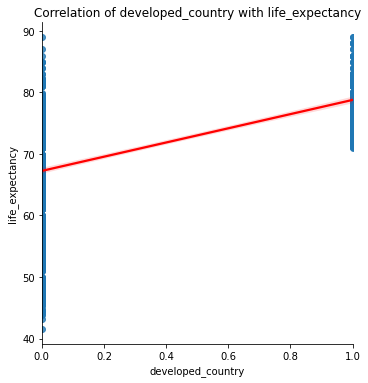

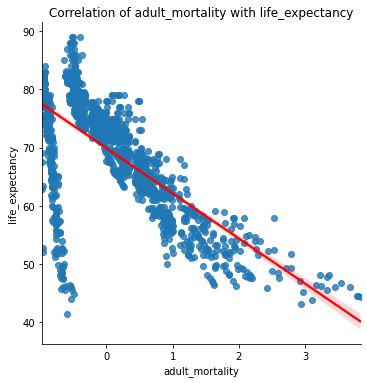

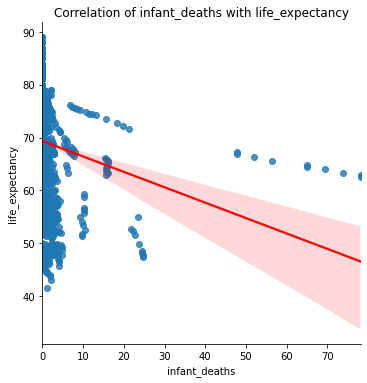

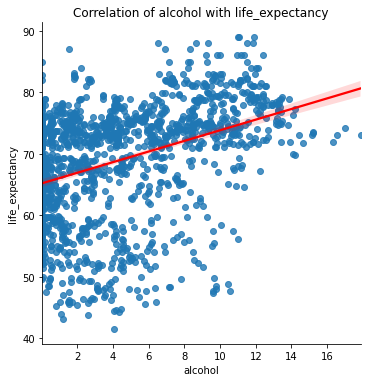

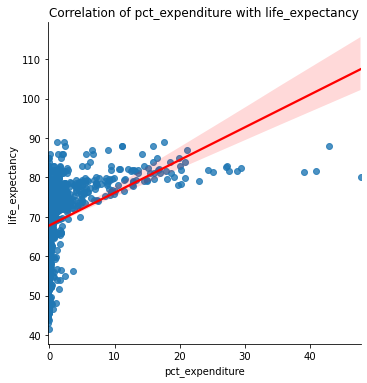

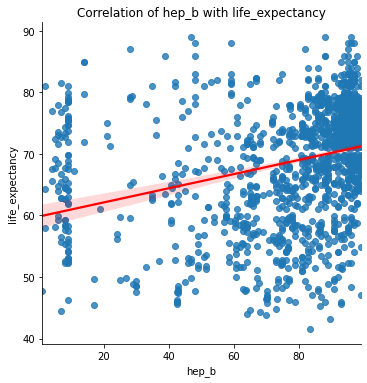

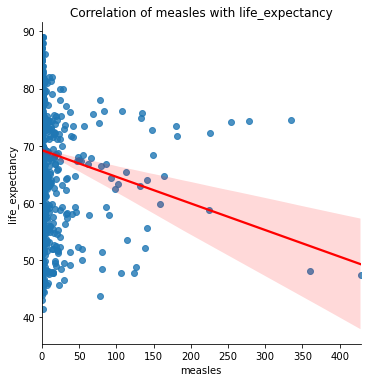

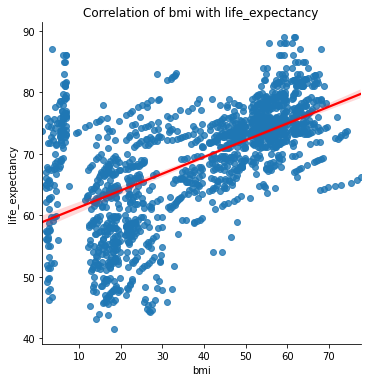

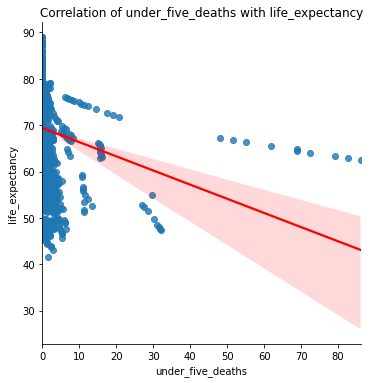

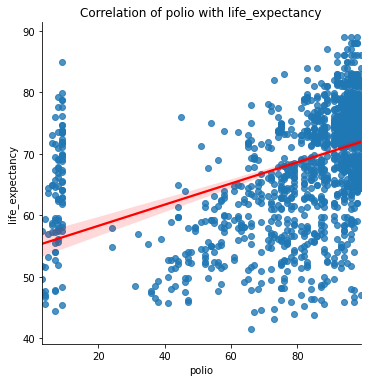

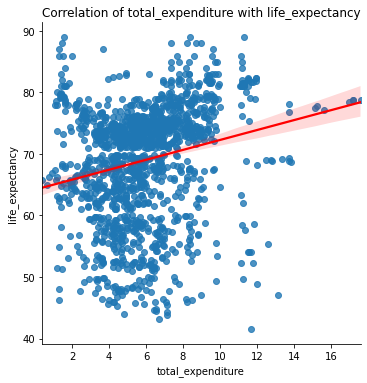

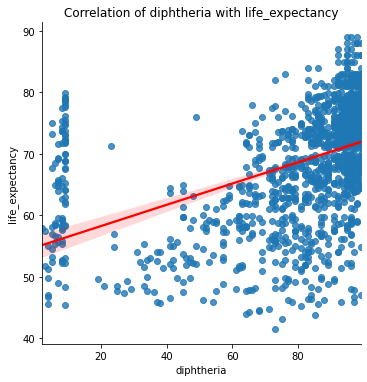

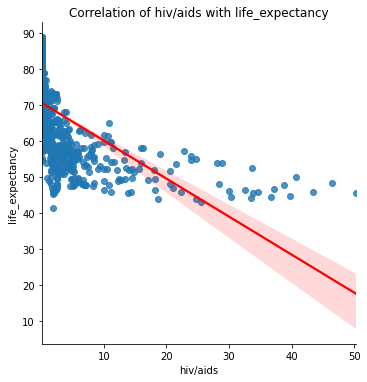

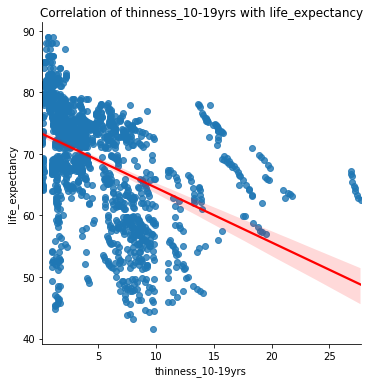

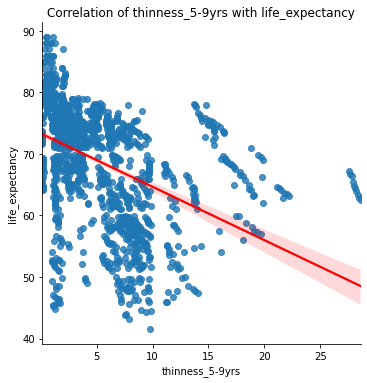

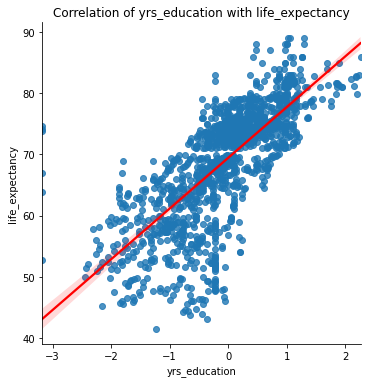

In [19]:
X = train_scaled.drop(columns=['life_expectancy', 'country'])
y = 'life_expectancy'
explore.lmplot(X, y, train_scaled)

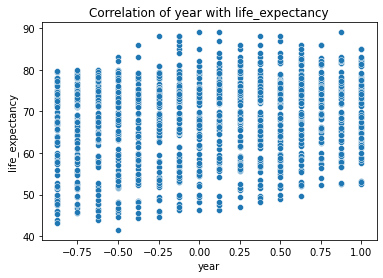

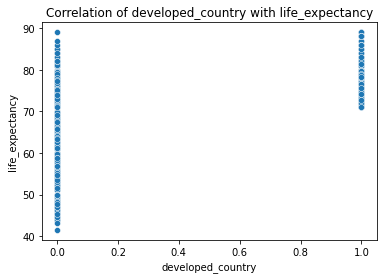

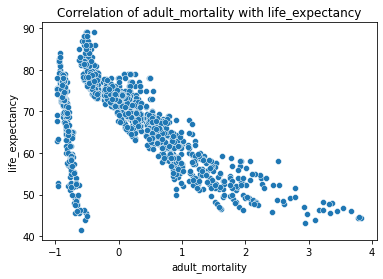

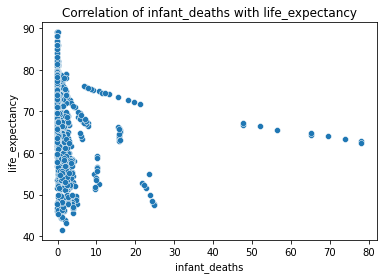

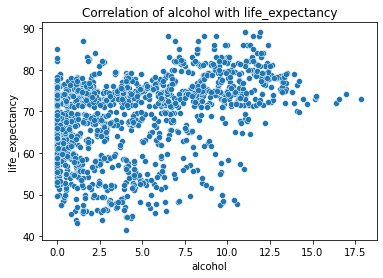

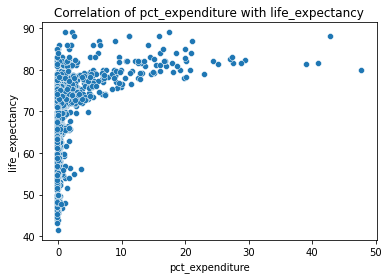

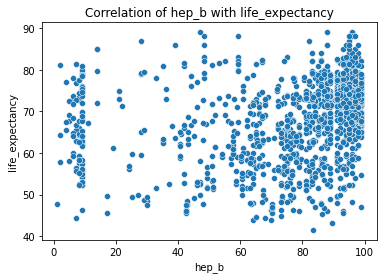

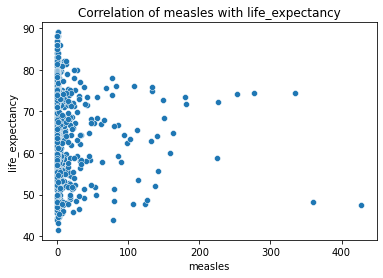

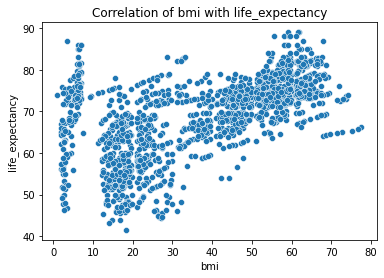

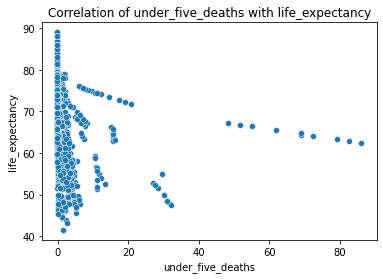

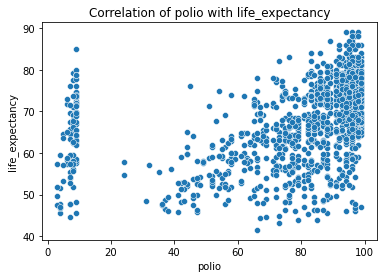

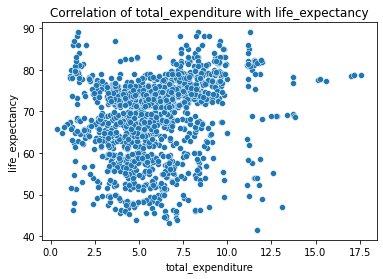

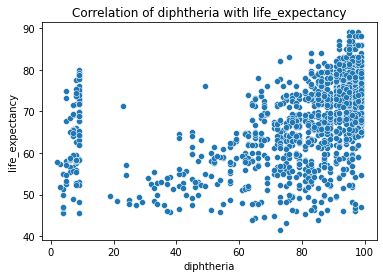

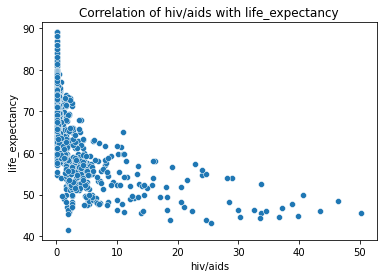

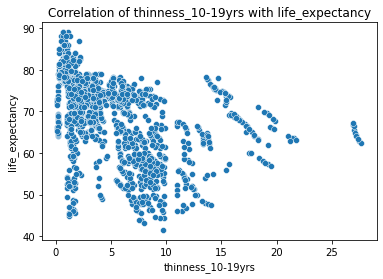

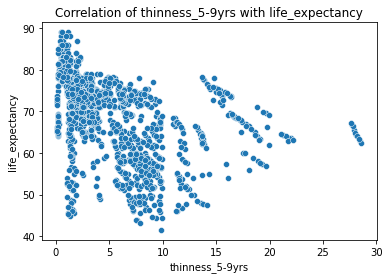

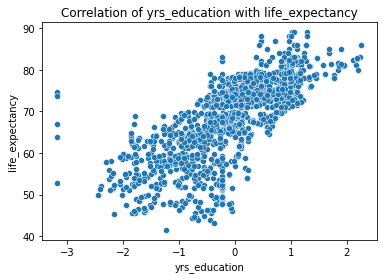

In [20]:
X = train_scaled.drop(columns=['life_expectancy', 'country'])
y= 'life_expectancy'

explore.scatterplot(X, y, train_scaled)

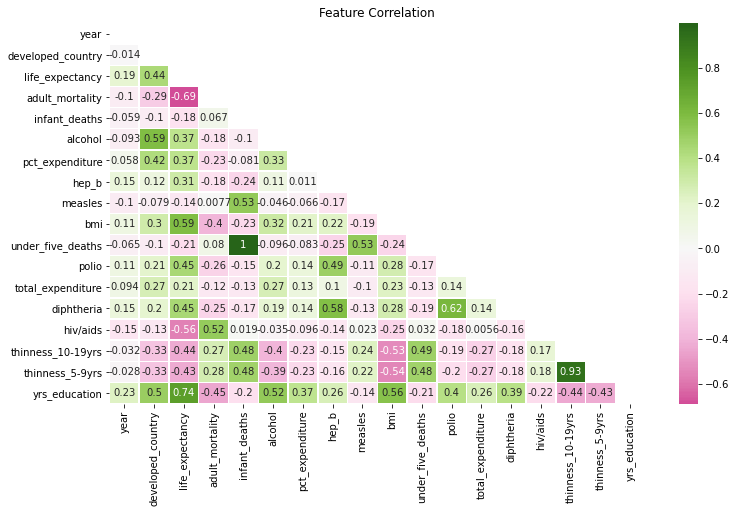

In [21]:
# take a look at a corner heatmap to assess correlation of independent and dependent variables
numerical = train_scaled
corr = numerical.corr()


plt.figure(figsize=(12,7))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, center=0, annot=True, linewidths=.5, cmap="PiYG", mask=mask)
plt.title('Feature Correlation')
plt.show()

I see a signification correlation of infant deaths and deaths under 5 years as well as thinness of variable ages to each other. These are repetitive features so it may be pointless to include both in the final model.

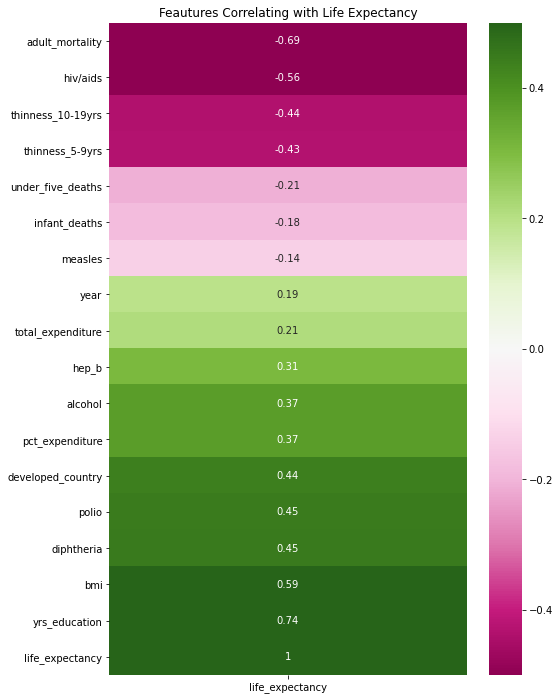

In [22]:
# Take a look at a heatmap of correlation to y target
plt.figure(figsize=(8,12))
value_heatmap = sns.heatmap(train_scaled.corr()[['life_expectancy']].sort_values(by='life_expectancy', ascending=True), cmap="PiYG", vmin=-.5, vmax=.5, annot=True)
value_heatmap.set_title('Feautures Correlating with Life Expectancy')
plt.show()

It's no surprise the year doesn't appear to have much correlation to life expectancy since the range is from 2000 to 2015.

I will confirm using a two sample two tailed ttest. My assumption is that I can accept the null hypothesis and confirm no correlation.

${H_0}$ = The mean average of the first half of years == The mean average of the second half of years
\
${H_a}$ = The mean average of the first half of years != The mean average of the second half of years

In [23]:
train.year.value_counts().sort_values()

 0.000     88
-0.250     88
 1.000     88
 0.125     89
 0.750     89
-0.375     89
-0.875     89
 0.625     93
 0.875     95
-0.125     96
 0.375     97
 0.250    100
 0.500    102
-0.750    103
-0.625    103
-0.500    107
Name: year, dtype: int64

In [24]:
# assess top features
top_features = explore.rfe(train_scaled.drop(columns=['country', 'life_expectancy']), train_scaled.life_expectancy, 9).to_list()
top_features

['developed_country',
 'adult_mortality',
 'infant_deaths',
 'alcohol',
 'pct_expenditure',
 'bmi',
 'under_five_deaths',
 'hiv/aids',
 'yrs_education']

## Modeling

In [25]:
# assign my top features from exploration
X_train = train[top_features]
X_validate = validate[top_features]
X_test = test[top_features]

# since both infant_deaths and under_five_deaths made it into top features and they are similar,
# we will drop one
X_train.drop(columns='infant_deaths', inplace=True)
X_validate.drop(columns='infant_deaths', inplace=True)
X_test.drop(columns='infant_deaths', inplace=True)

In [26]:
# split X and y dataframes using my split_ytarget function
# X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle.split_ytarget(train, validate, test, 'life_expectancy')